# Selección del clasificador

Alfredo Rodríguez Magdalena ©

In [46]:
import warnings
warnings.filterwarnings("ignore")

import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
import seaborn as sns

## Importación de los datos de entrenamiento

In [47]:
data1 = mat73.loadmat(r'../datos/experimento3_sep.mat')
labels1 = scipy.io.loadmat(r'../datos/labelsExperimento3.mat')
Vr14 = scipy.io.loadmat(r'../datos/Vr14.mat')

X1 = data1["X"]
U1 = data1["U"]
N1 = data1["N"]
Y1 = labels1['Y']
Vr14 = Vr14['Vr']

data2 = mat73.loadmat(r'../datos/experimento4_sep.mat')
labels2 = scipy.io.loadmat(r'../datos/labelsExperimento4.mat')
X2 = data2["X"]
U2 = data2["U"]
N2 = data2["N"]
Y2 = labels2['Y']

#X = np.concatenate((X1, X2), axis=0)
#U = np.concatenate((U1, U2), axis=0)
#N = np.concatenate((N1, N2), axis=0)
#Y = np.concatenate((Y1, Y2), axis=0)

X = X1
U = U1
N = N1
Y = Y1

tm = 5e-3 # Tiempo de muestreo

print(f"Dimensiones de la matriz de datos : {X.shape}")
print(f"Dimensiones de las etiquetas : {Y.shape}")
print(f"Dimensiones de la matriz de entradas : {U.shape}")
print(f"Número de experimentos : {N.shape}")
print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")

Dimensiones de la matriz de datos : (11953, 500)
Dimensiones de las etiquetas : (11953, 1)
Dimensiones de la matriz de entradas : (11953, 3)
Número de experimentos : (36,)
Dimensiones de la matriz de cambio de base : (15, 500)


In [48]:
# Seleccionar 10 índices aleatorios
#indices_aleatorios = np.random.choice(X.shape[0], 10, replace=False)

# Seleccionar los perfiles, sus etiquetas y velocidades correspondientes
#perfiles_aleatorios = X[indices_aleatorios]
#etiquetas_aleatorias = Y[indices_aleatorios]
#velocidades_aleatorias = U[indices_aleatorios, 0]

# Crear un DataFrame con los perfiles, las etiquetas y las velocidades
#perfiles_df = pd.DataFrame(perfiles_aleatorios, columns=[f"Feature_{i}" for i in range(X.shape[1])])
#perfiles_df['Etiqueta'] = etiquetas_aleatorias
#perfiles_df['Velocidad'] = velocidades_aleatorias

# Exportar el DataFrame a un archivo CSV
#perfiles_df.to_csv("perfiles_aleatorios.csv", index=False)

In [49]:
# Importar la matriz de perfiles aleatorios desde el archivo CSV
perfiles_df = pd.read_csv("perfiles_aleatorios.csv")

# Extraer los perfiles (todas las columnas excepto 'Etiqueta' y 'Velocidad')
perfiles = perfiles_df.drop(columns=['Etiqueta', 'Velocidad']).values

print(perfiles.shape)

alphaAA = Vr14 @ perfiles.T
print(alphaAA)

(10, 500)
[[-3.48529220e+01 -4.42027596e+01 -6.51193539e+01 -5.61530752e+01
  -3.70385719e+01 -6.01103020e+01 -5.94888948e+01 -5.32693057e+01
  -4.25581166e+01 -6.34096732e+01]
 [-8.29756250e+00 -9.76132300e+00 -2.73512059e-01  1.77786882e+00
  -5.41344405e+00  8.59030633e-01  2.91339550e+00  2.82780438e+00
  -9.39986693e+00 -4.19671224e+00]
 [ 2.61484352e+00  1.07107172e+00  8.87529617e+00  6.03876313e+00
   5.91838565e+00  6.07161613e+00  9.20076719e+00  5.24154723e+00
   6.95710775e-01  9.27863157e+00]
 [ 3.43905766e+00  2.21071489e+00  5.34466983e+00  5.49256412e+00
   5.02509853e+00  3.44031883e+00  3.99688151e+00  6.64249298e+00
   1.83122646e+00  2.44476873e+00]
 [ 1.28839320e+00  5.75140623e-01 -1.08191729e+00  7.67473832e-01
   1.21045494e+00  6.20301323e-01 -3.84150662e-01 -6.91812992e-01
   1.09950244e+00  5.09690786e-01]
 [-1.35932977e+00 -1.43873485e+00 -6.66868762e+00  4.73908696e-02
  -2.76716576e+00  1.06324085e-01 -5.06183149e+00  4.11752280e-01
  -1.57775821e+00 -9.92

In [50]:
scalerX = StandardScaler()
Xnormalizado = scalerX.fit_transform(X)
Unormalizado = U[:,0] / 1000 # Se expresa en m/s

In [51]:
# DS1 -> Todos los datos sin tratar
X1 = np.hstack((Xnormalizado, Unormalizado.reshape(-1,1)))

print(f"Dimensiones de dataset 1 : {X1.T.shape} (características, muestras)")

Dimensiones de dataset 1 : (501, 11953) (características, muestras)


In [52]:
# DS2 -> Datos en la base de Vr14
X2 = Vr14 @ X.T
X2 = np.hstack((X2.T, U[:,0].reshape(-1,1)))

print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")
print(f"Dimensiones de dataset 2 : {X2.T.shape} (características, muestras)")

Dimensiones de la matriz de cambio de base : (15, 500)
Dimensiones de dataset 2 : (16, 11953) (características, muestras)


In [53]:
# DS3 -> Datos deducidos a partir de la etapa de extracción de características superficial
X3 = data1["F"]
X3 = np.hstack((X3, U[:,0].reshape(-1,1)))

print(f"Dimensiones de dataset 3 : {X3.T.shape} (características, muestras)")

Dimensiones de dataset 3 : (3, 11953) (características, muestras)


In [54]:
datasets = {"DS1" : X1, 
            "DS2" : X2,
            "DS3" : X3}

## Entrenamiento de modelos

In [55]:
semilla = 92
np.random.seed(semilla) # Semilla para reproducibilidad

In [56]:
# Diccionario con los algoritmos de clasificación
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "SGD Classifier": SGDClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "ANN": MLPClassifier(max_iter=300),
}

In [57]:
print(np.ravel(Y).shape)

(11953,)


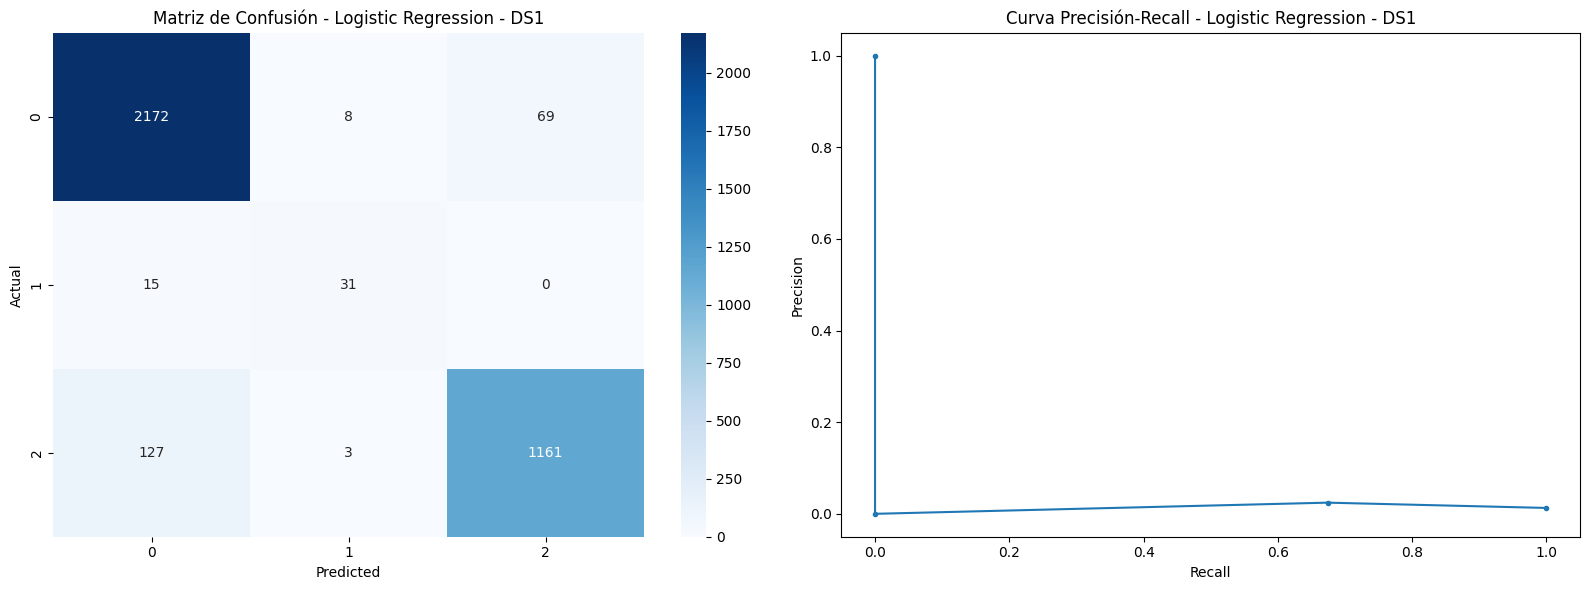

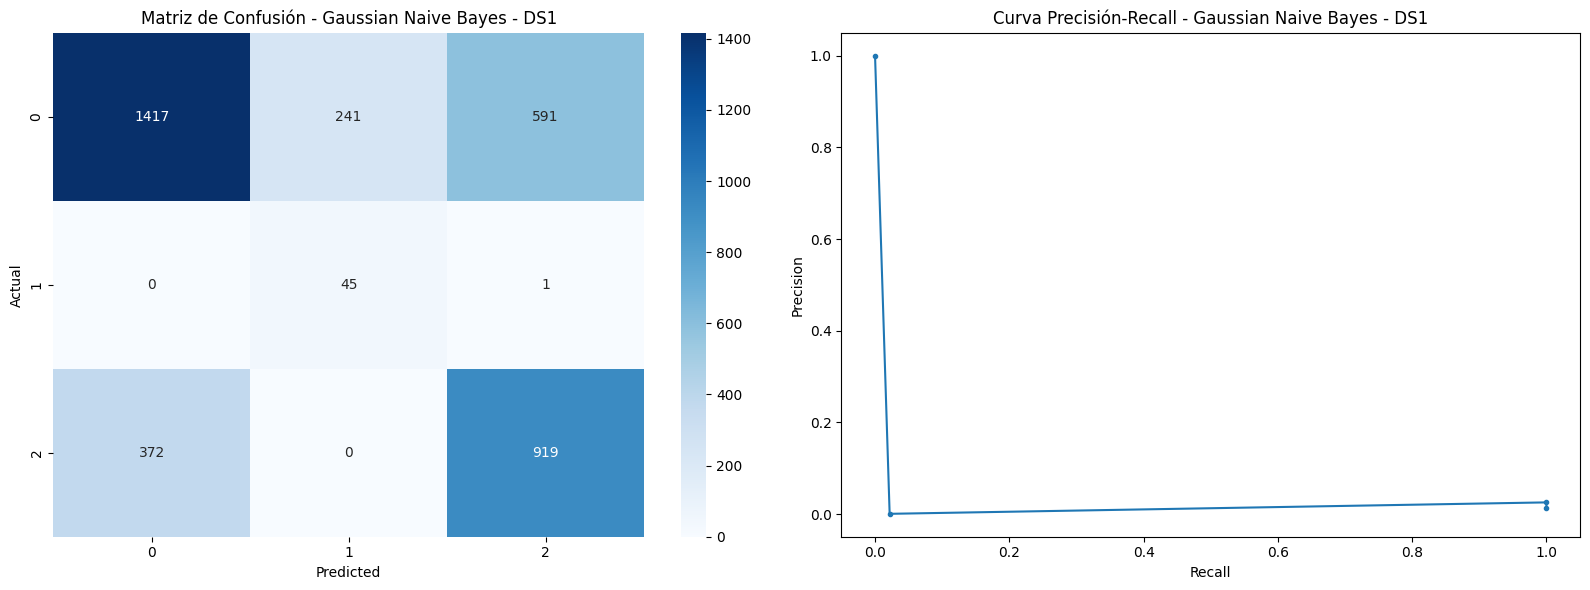

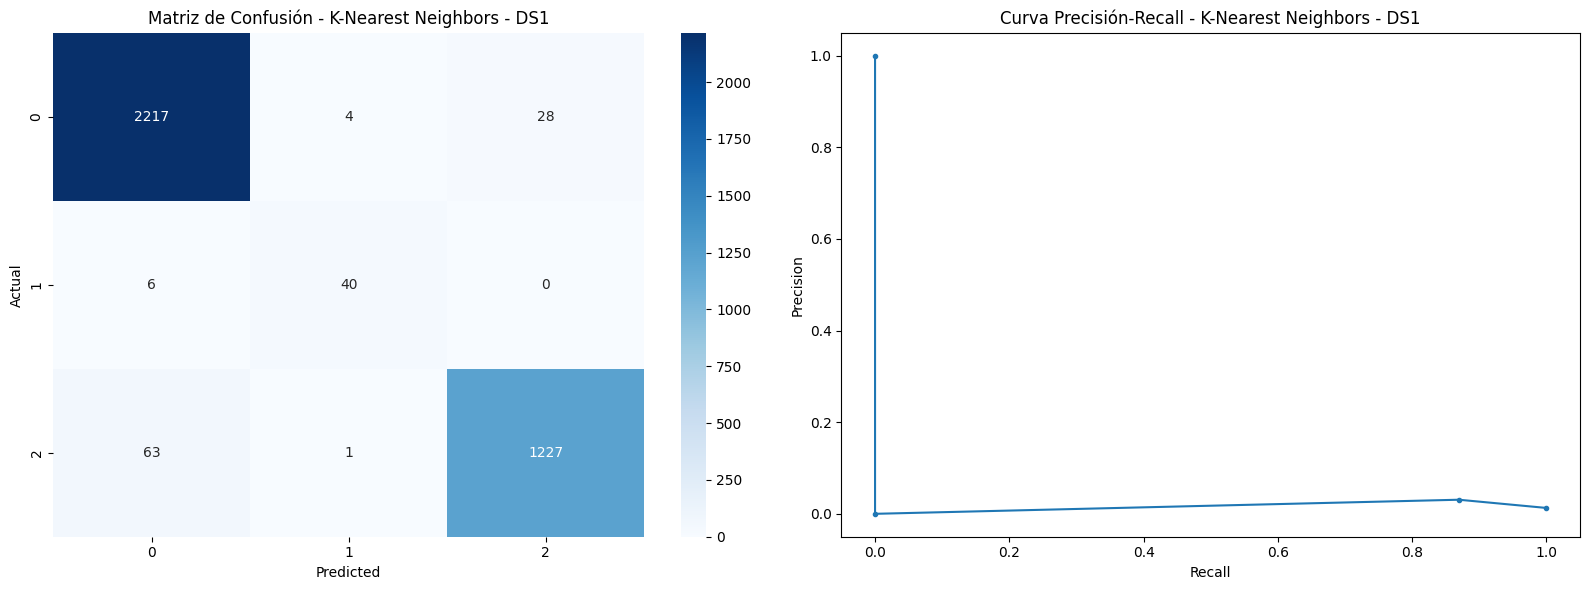

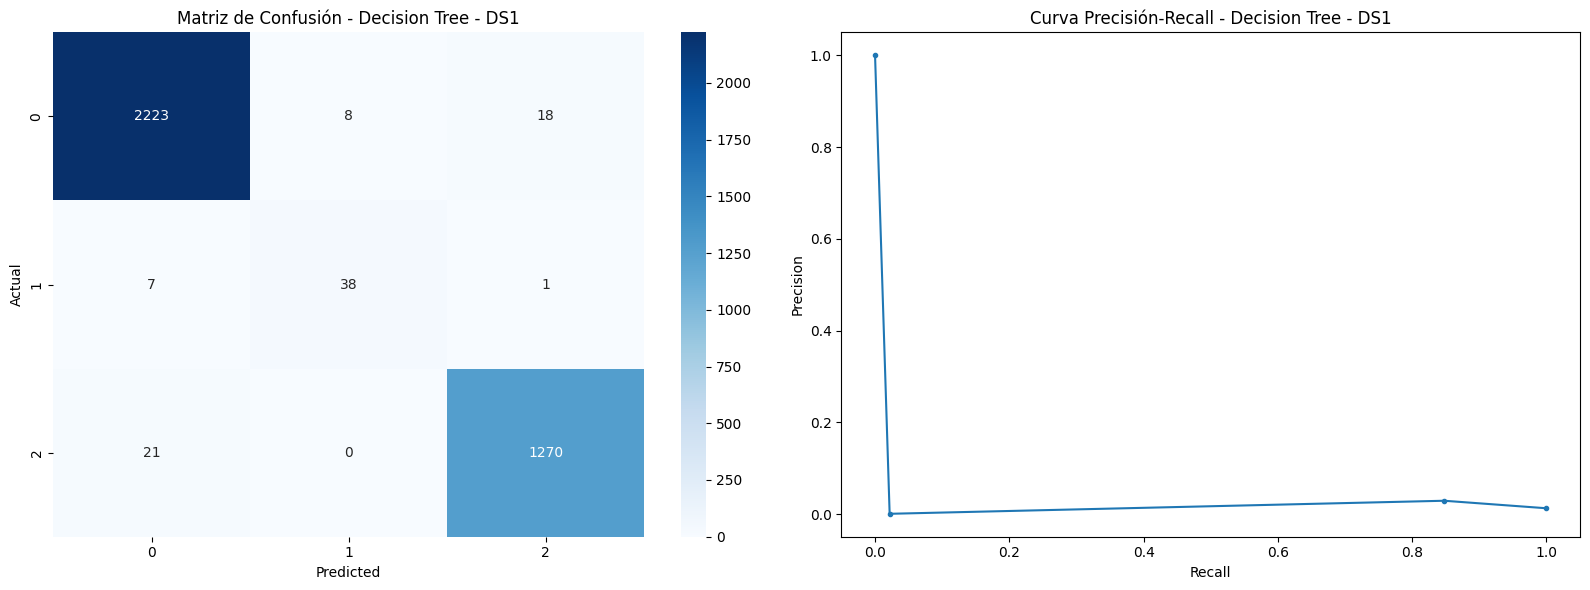

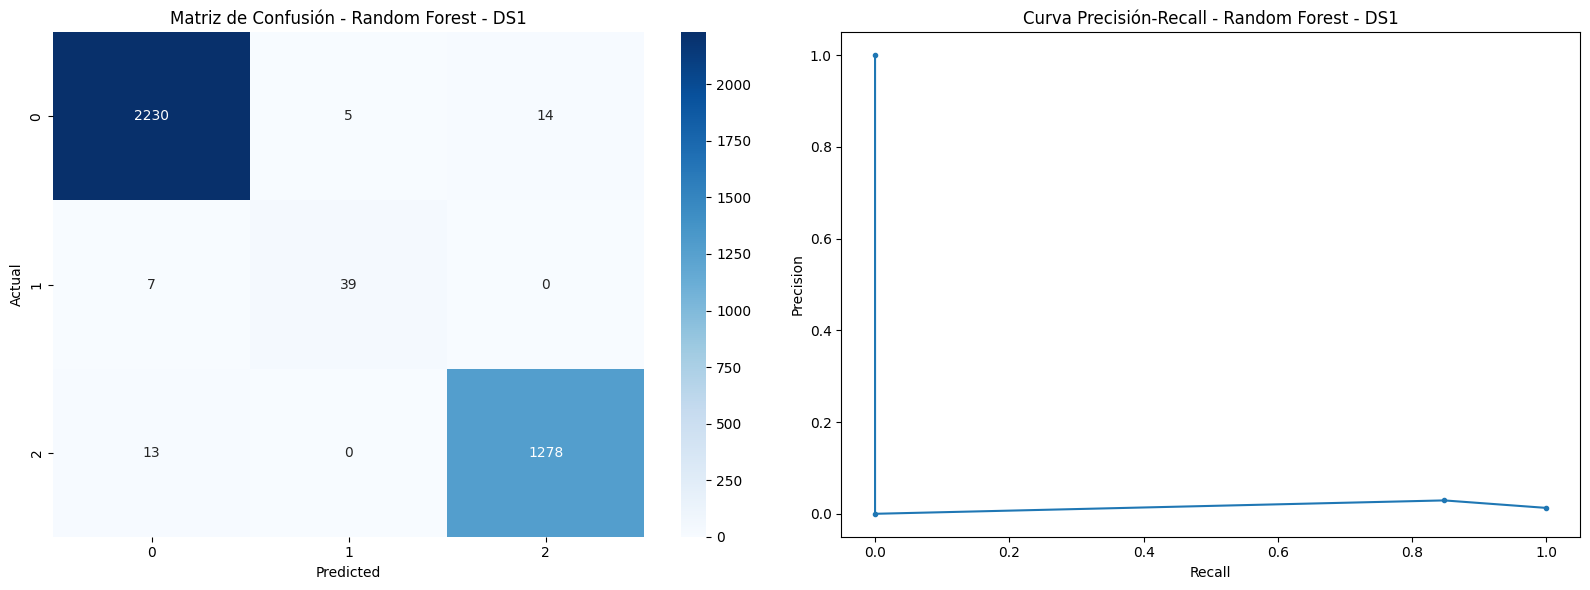

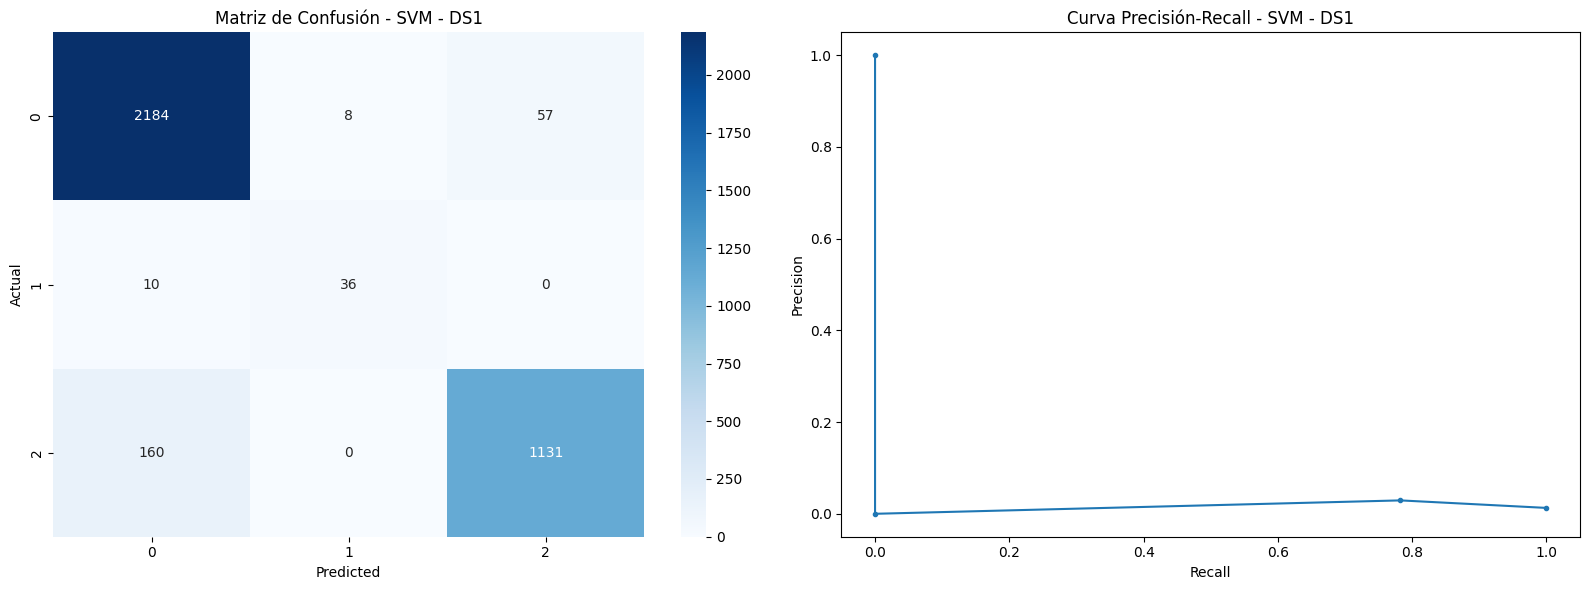

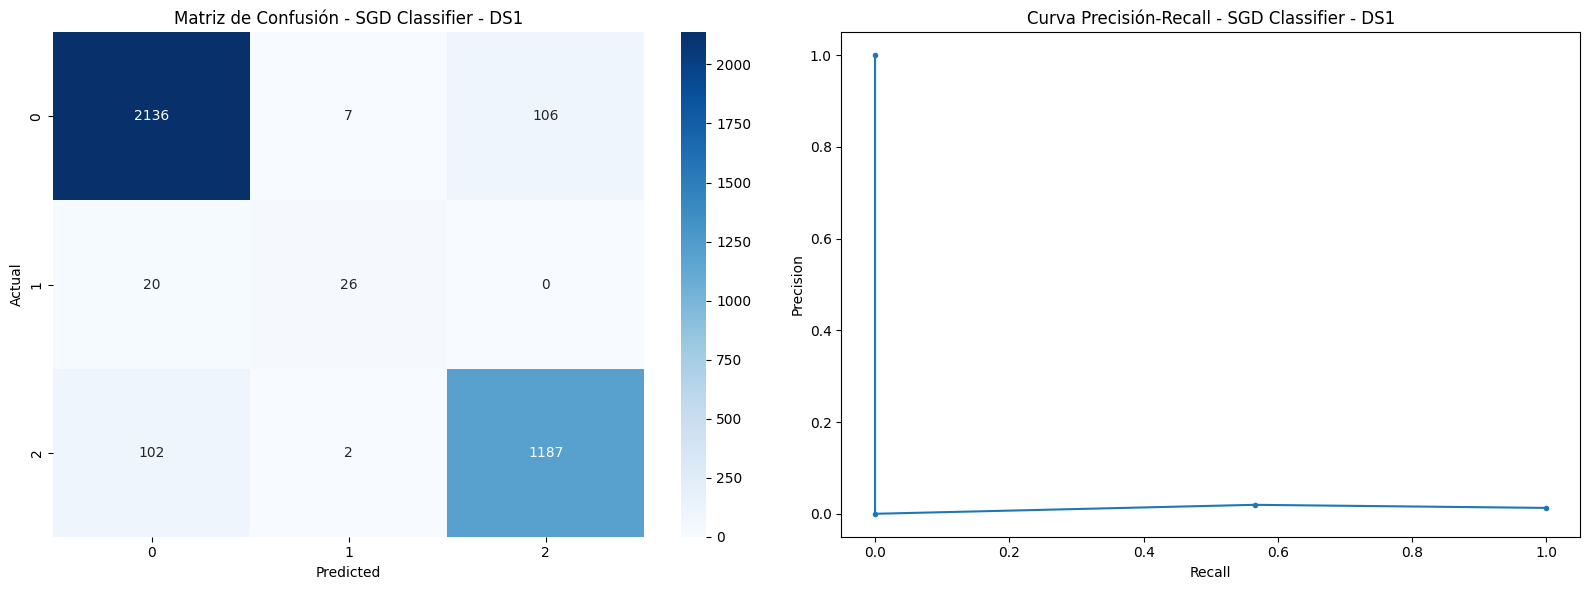

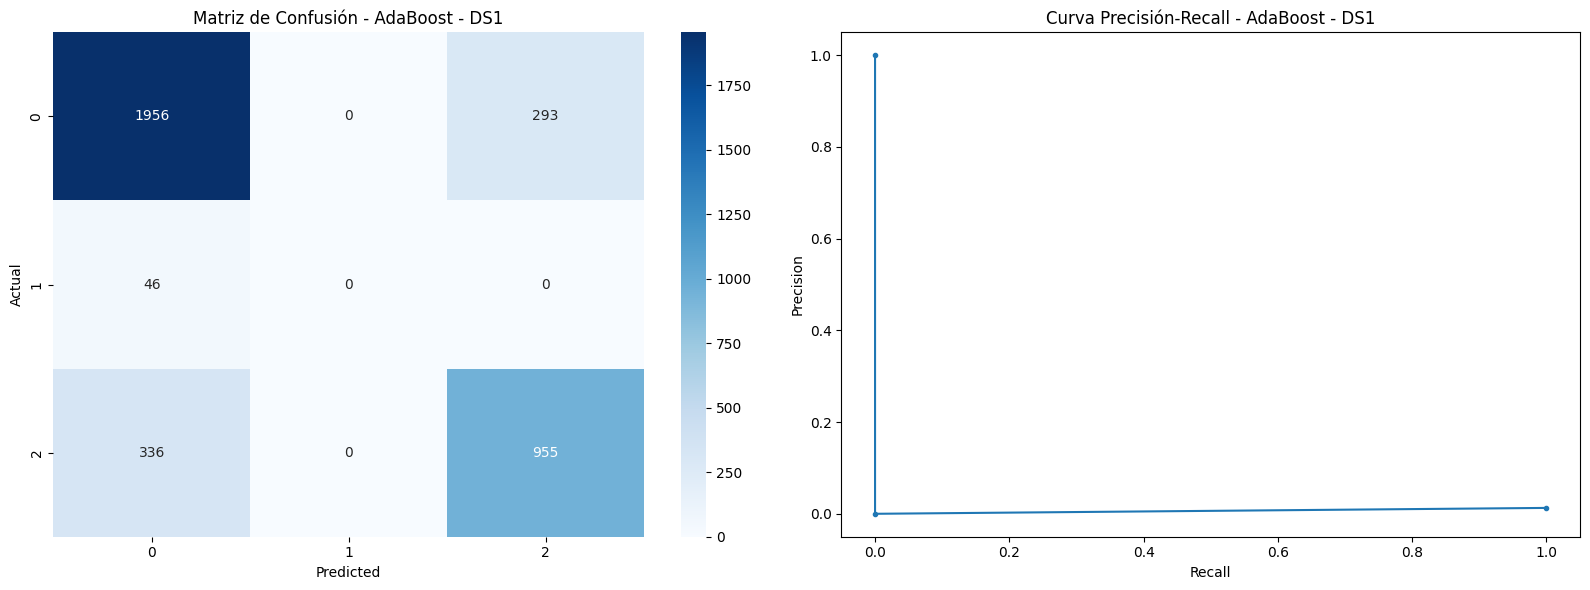

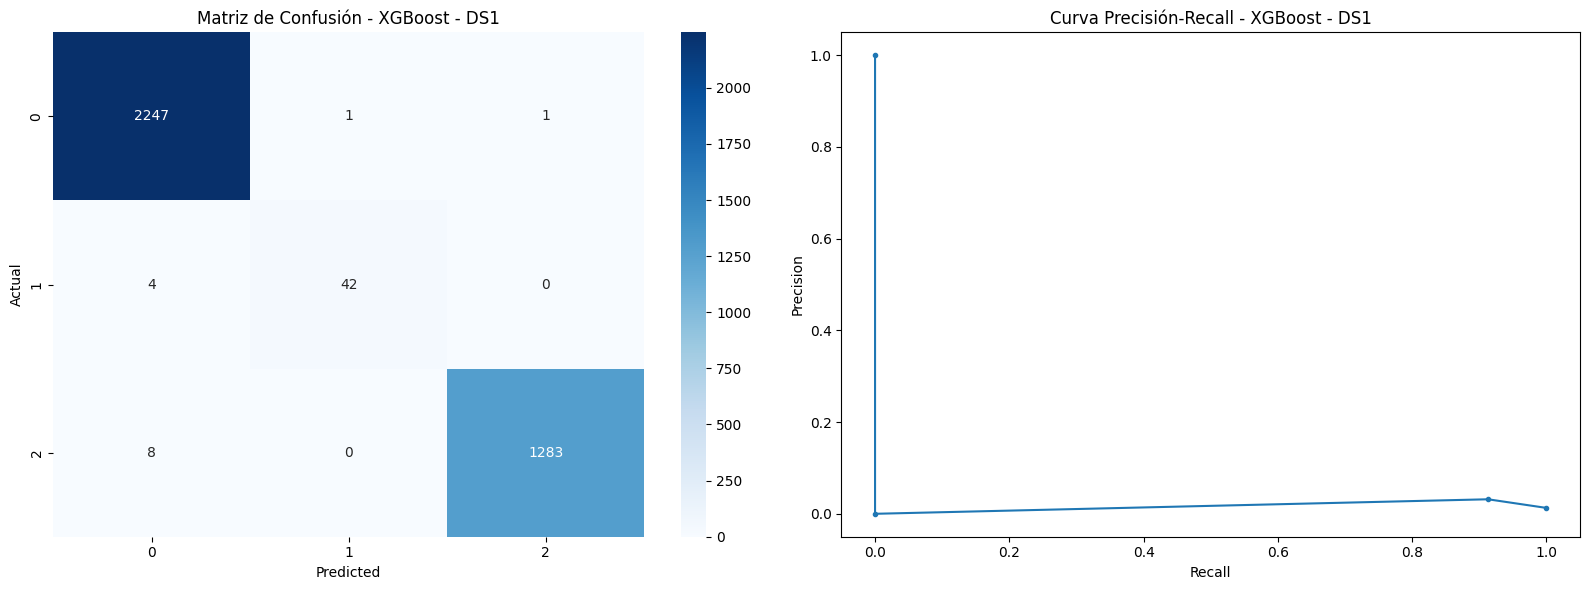

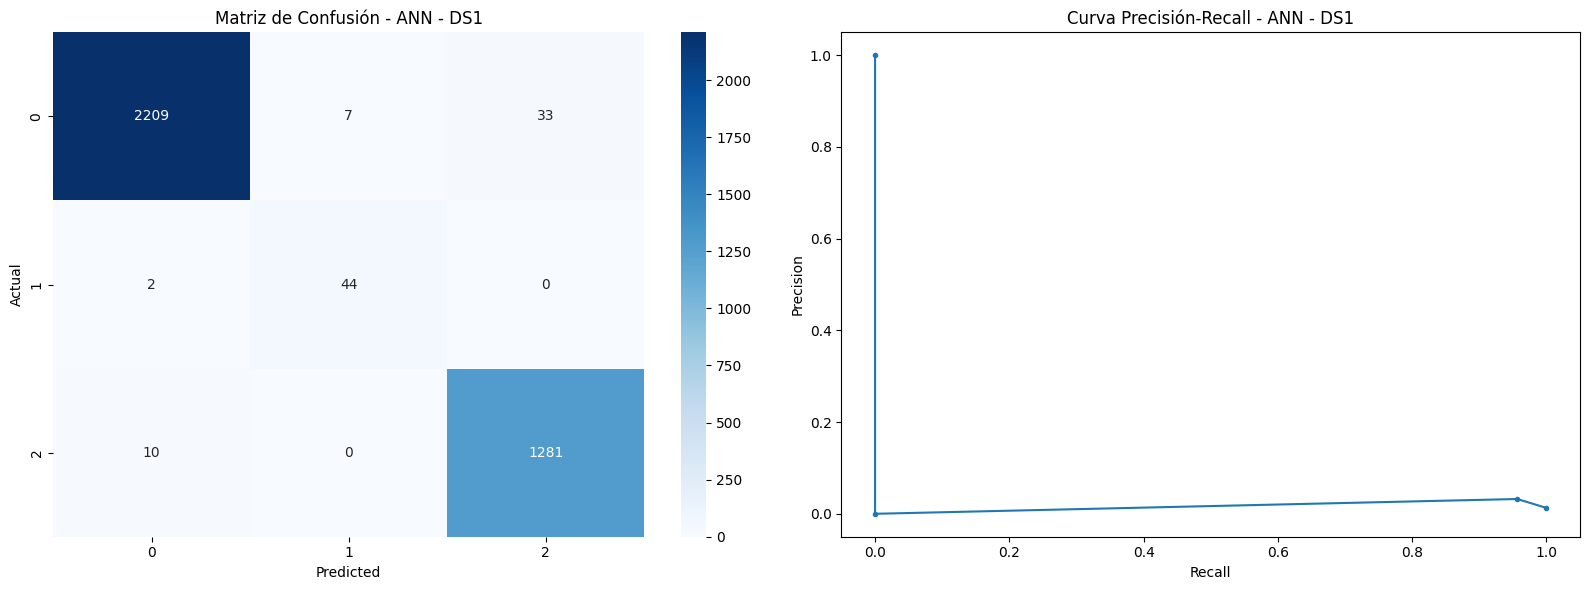

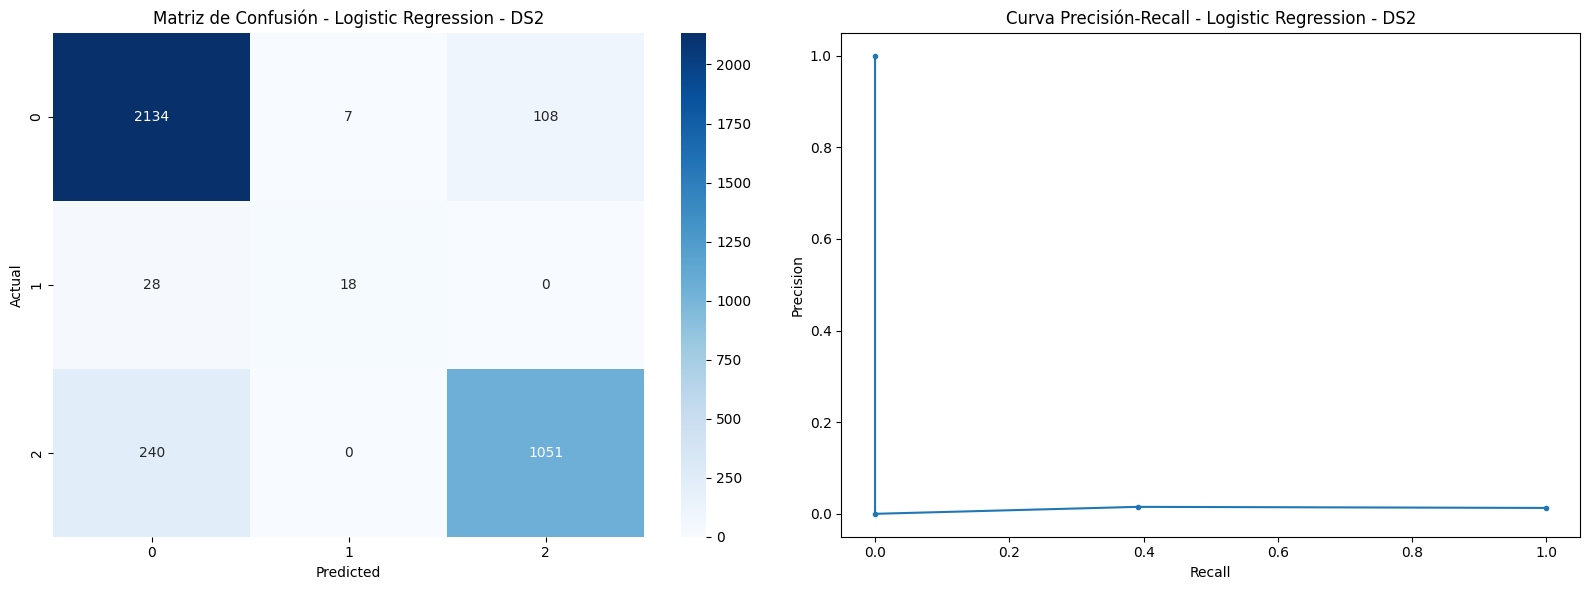

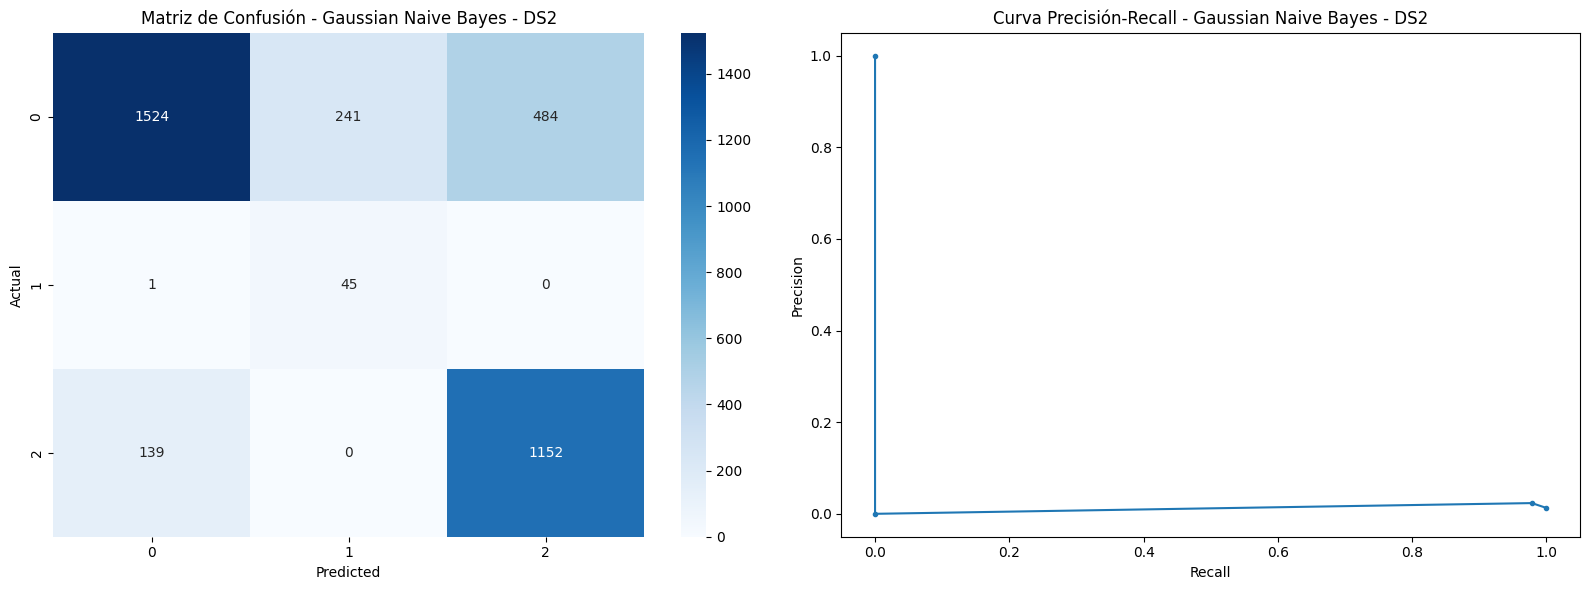

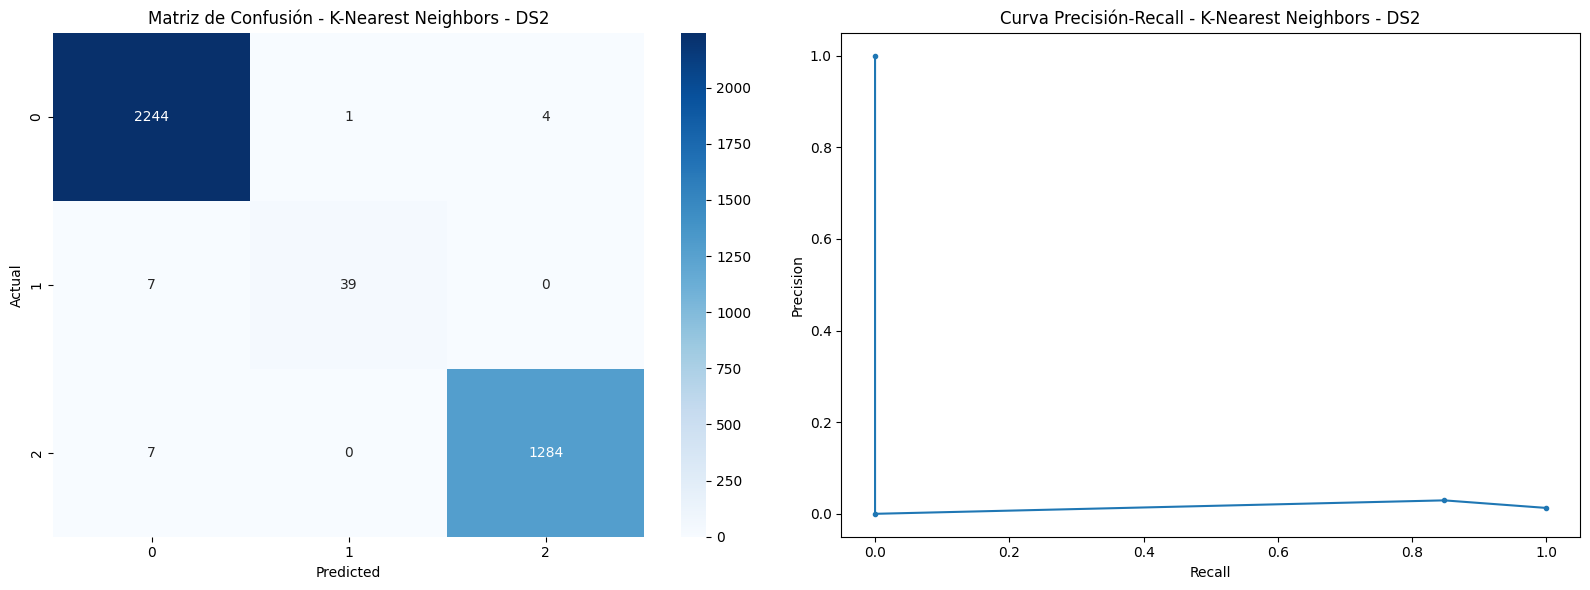

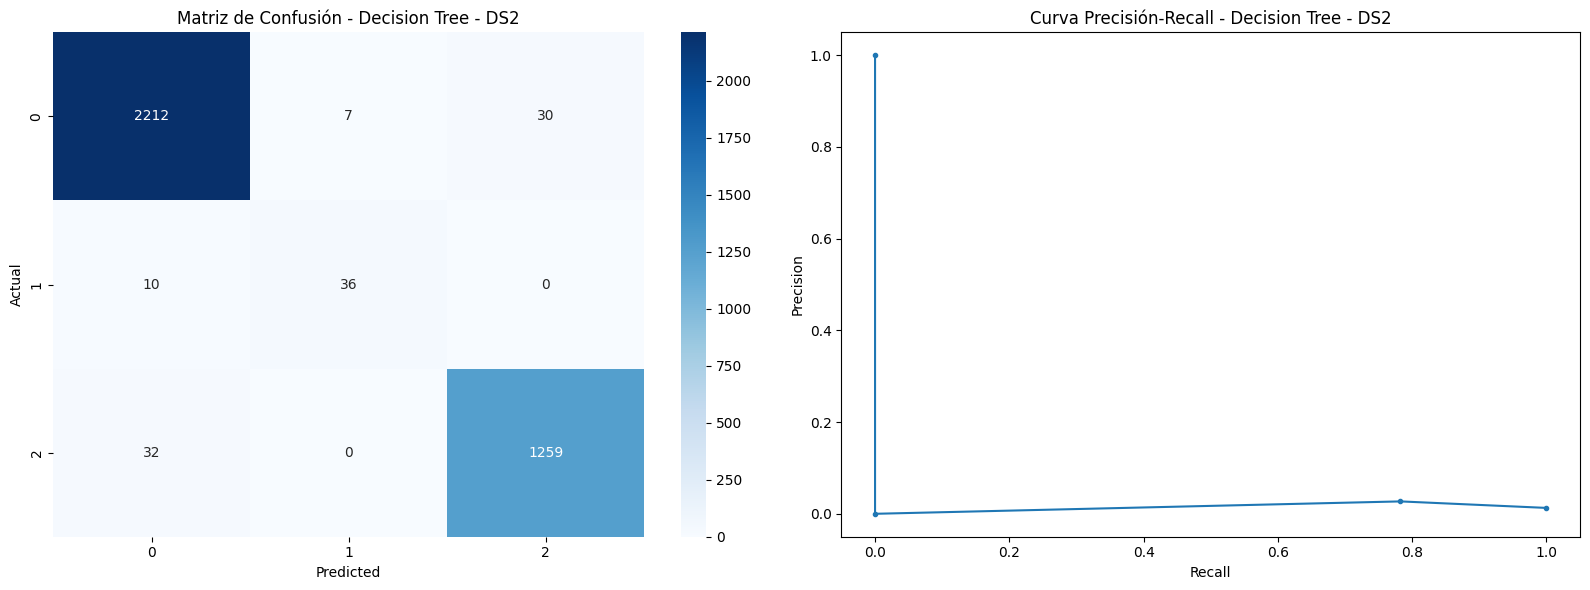

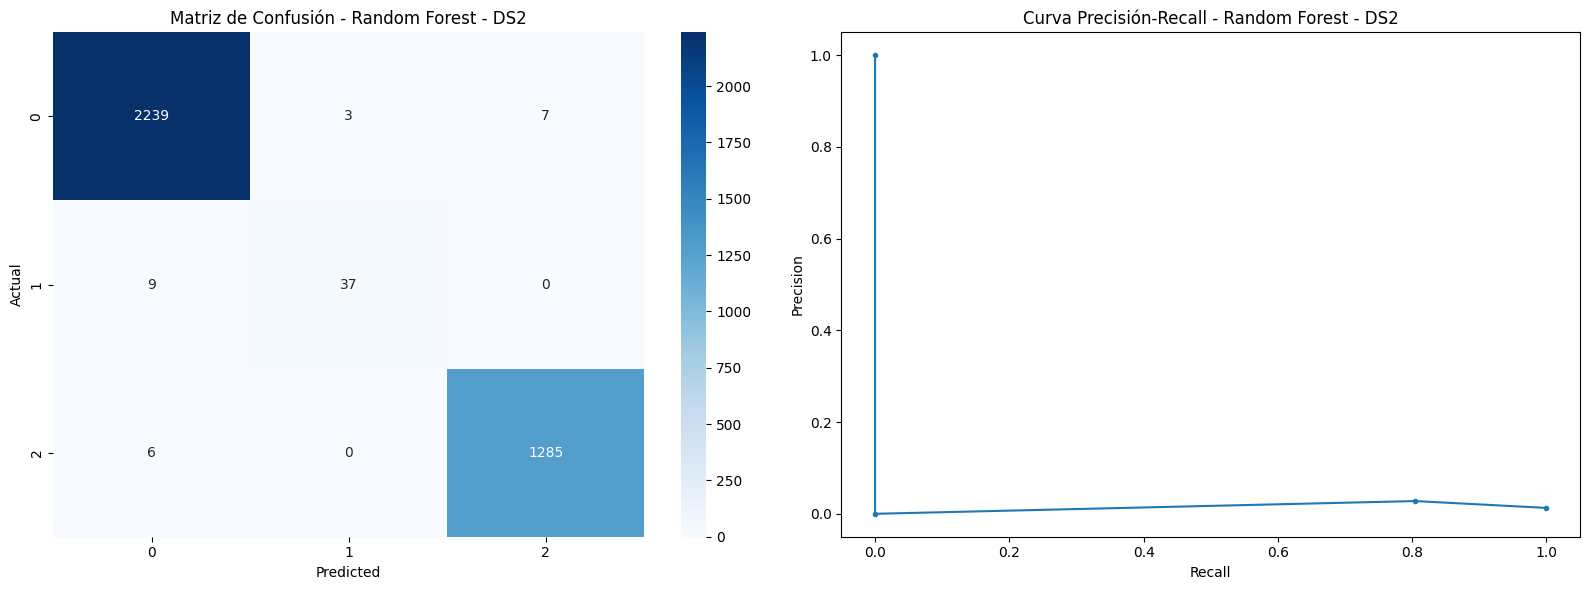

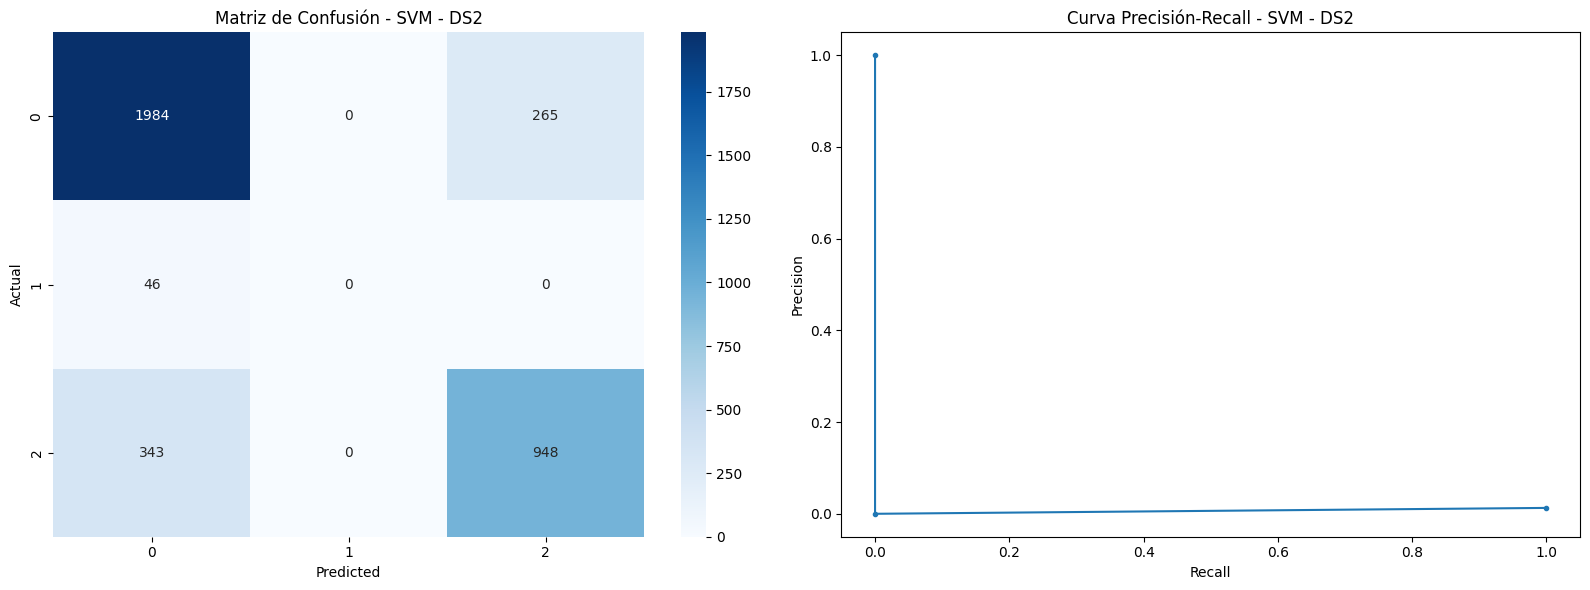

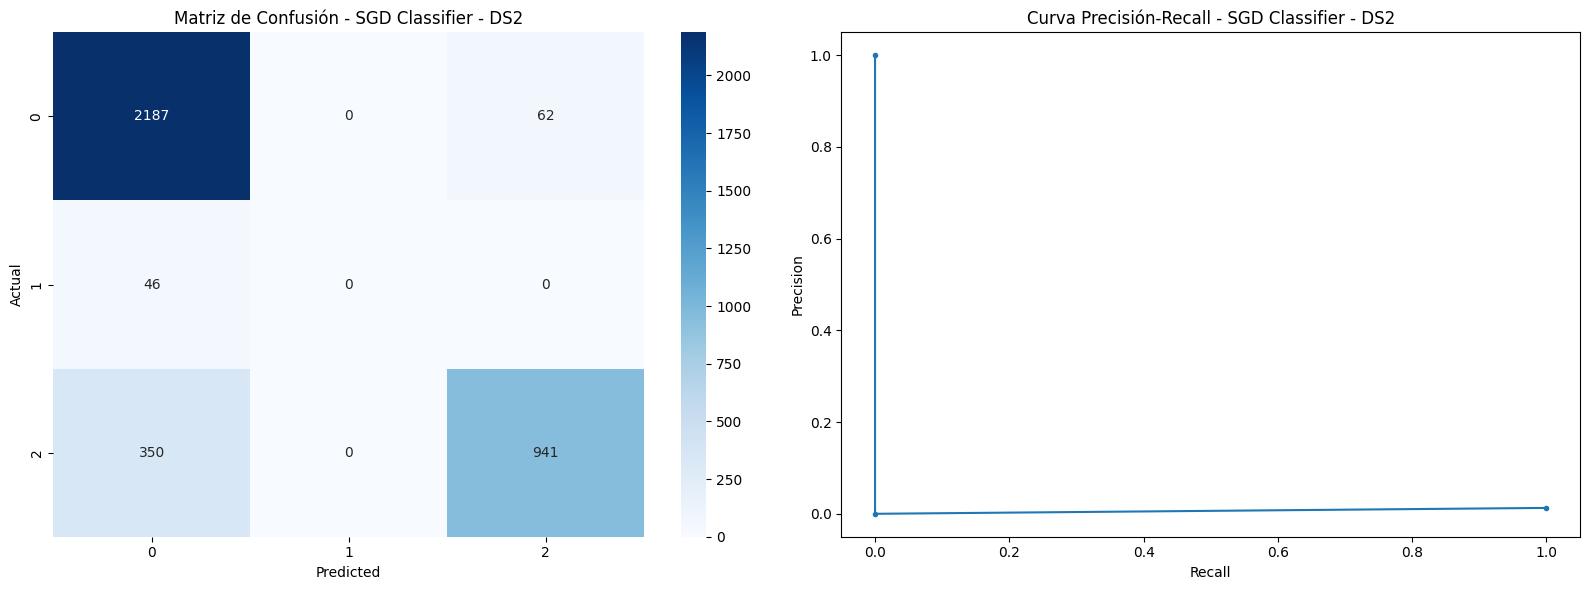

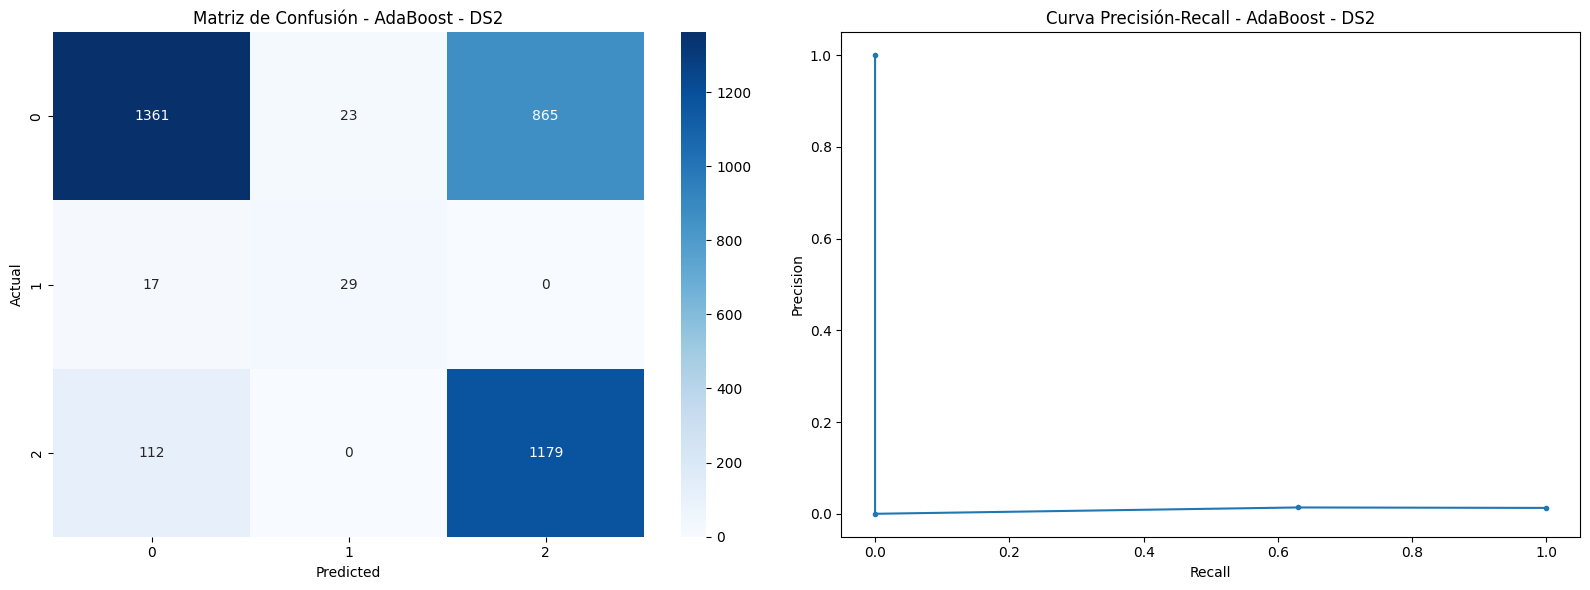

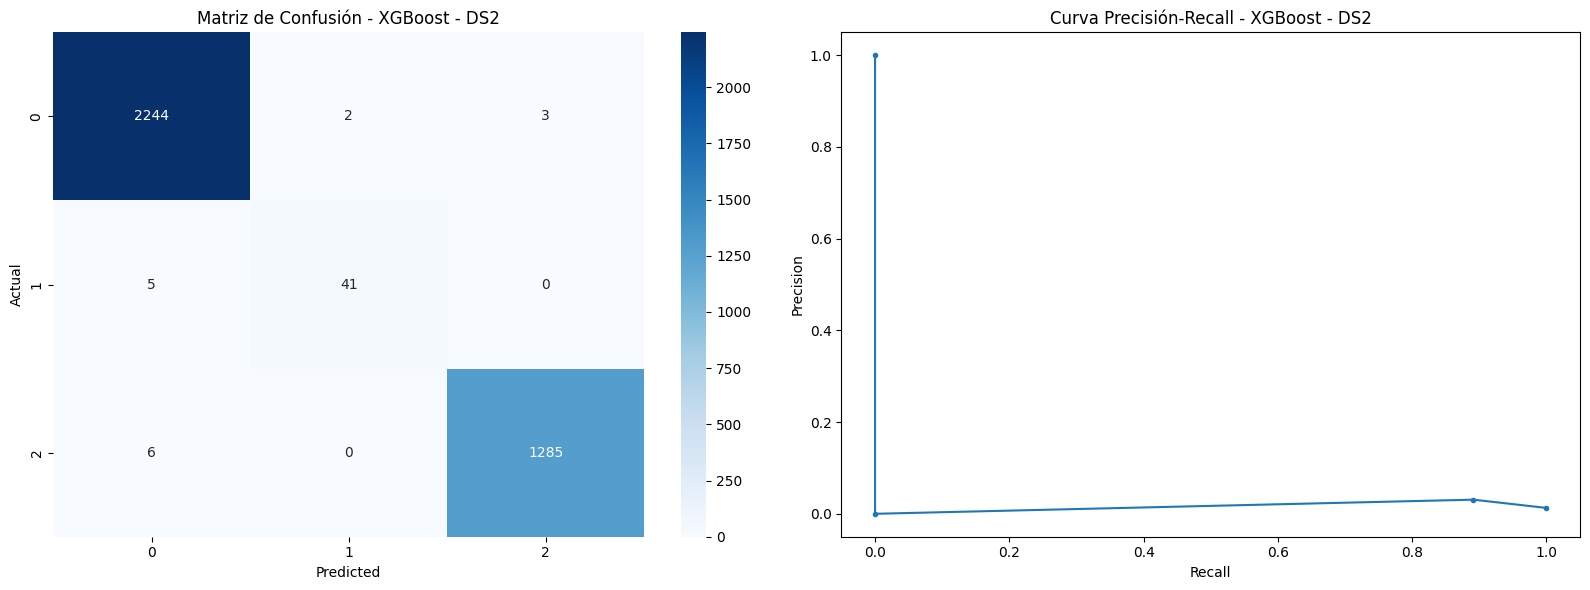

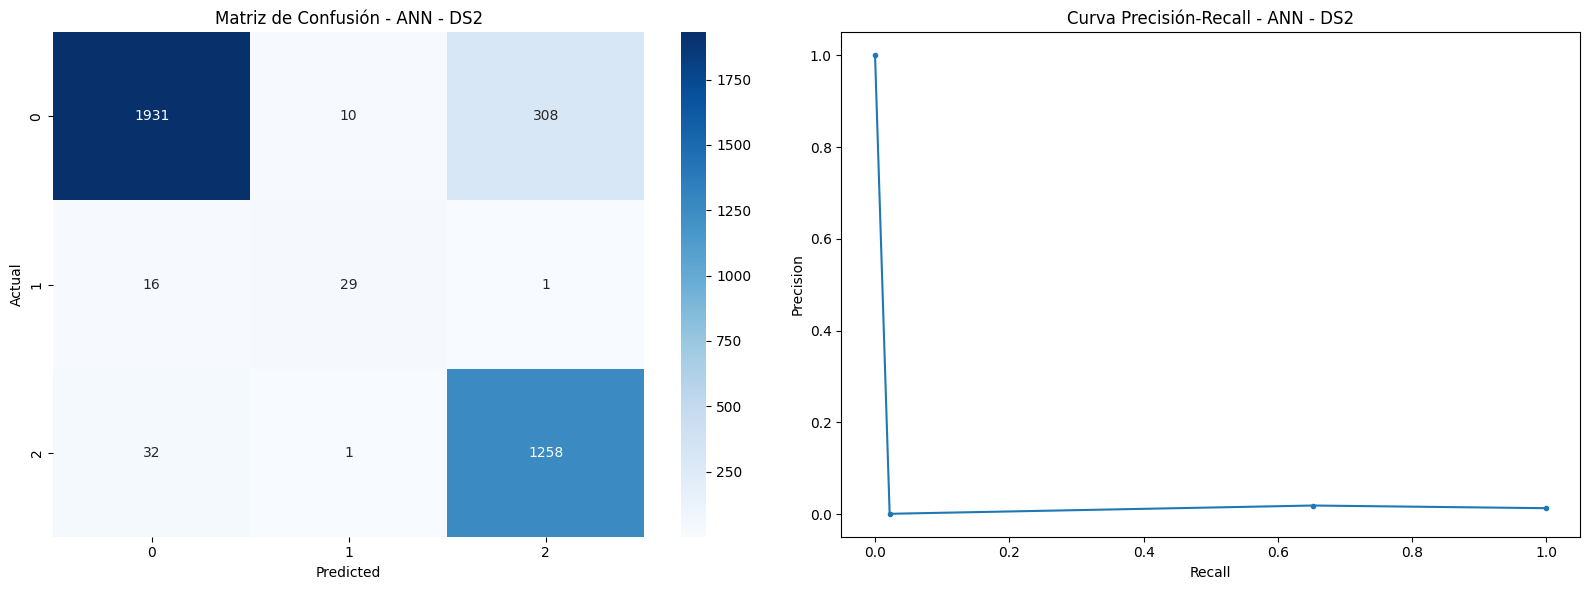

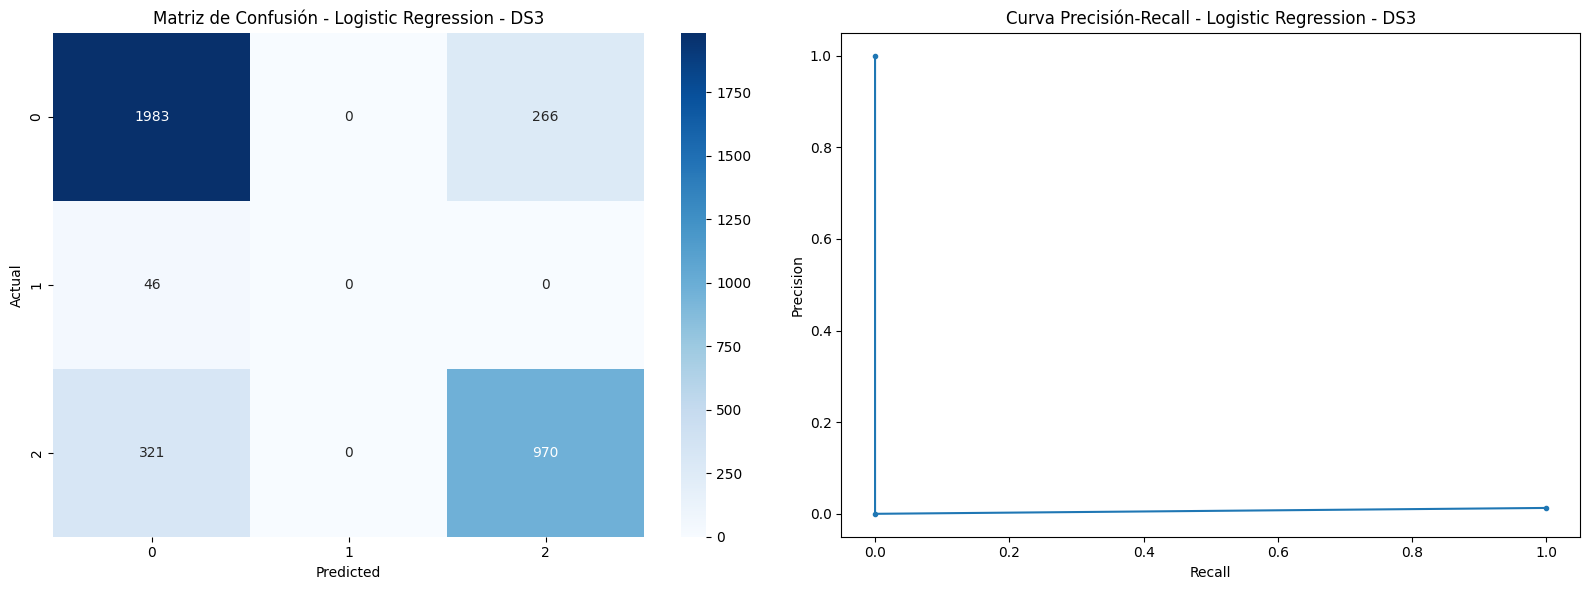

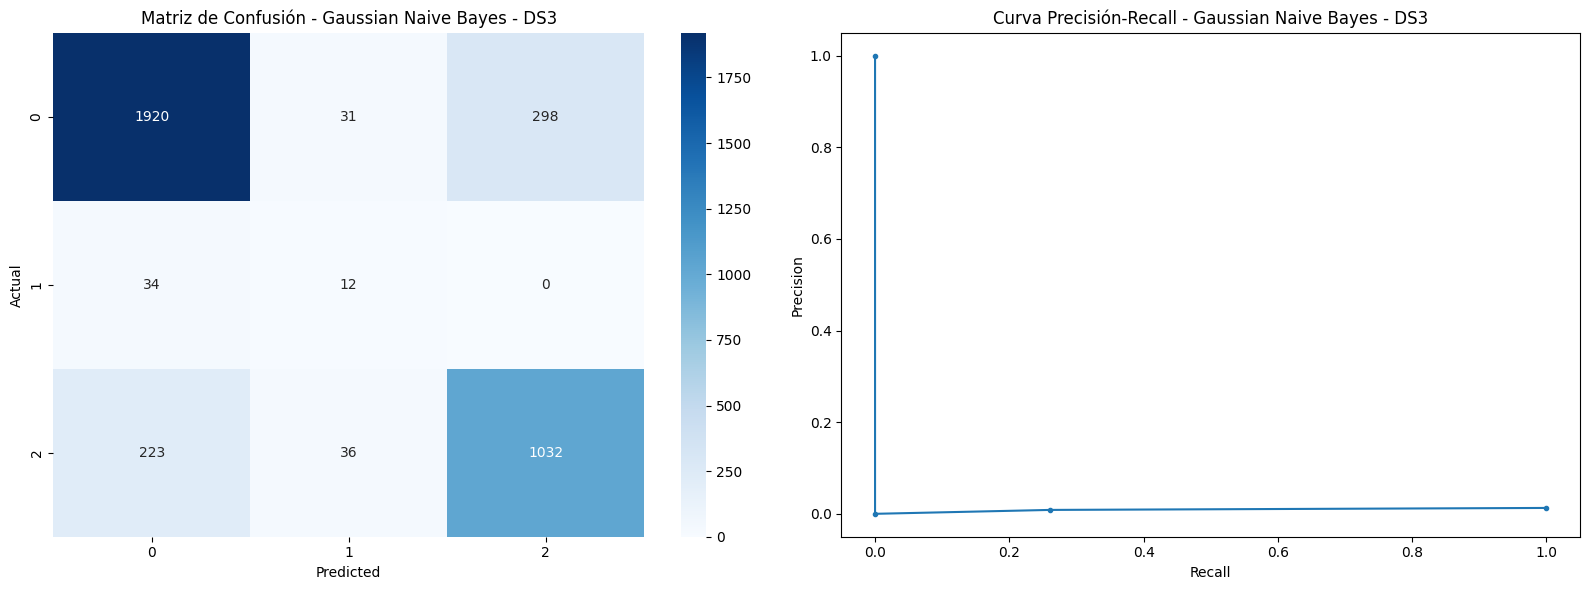

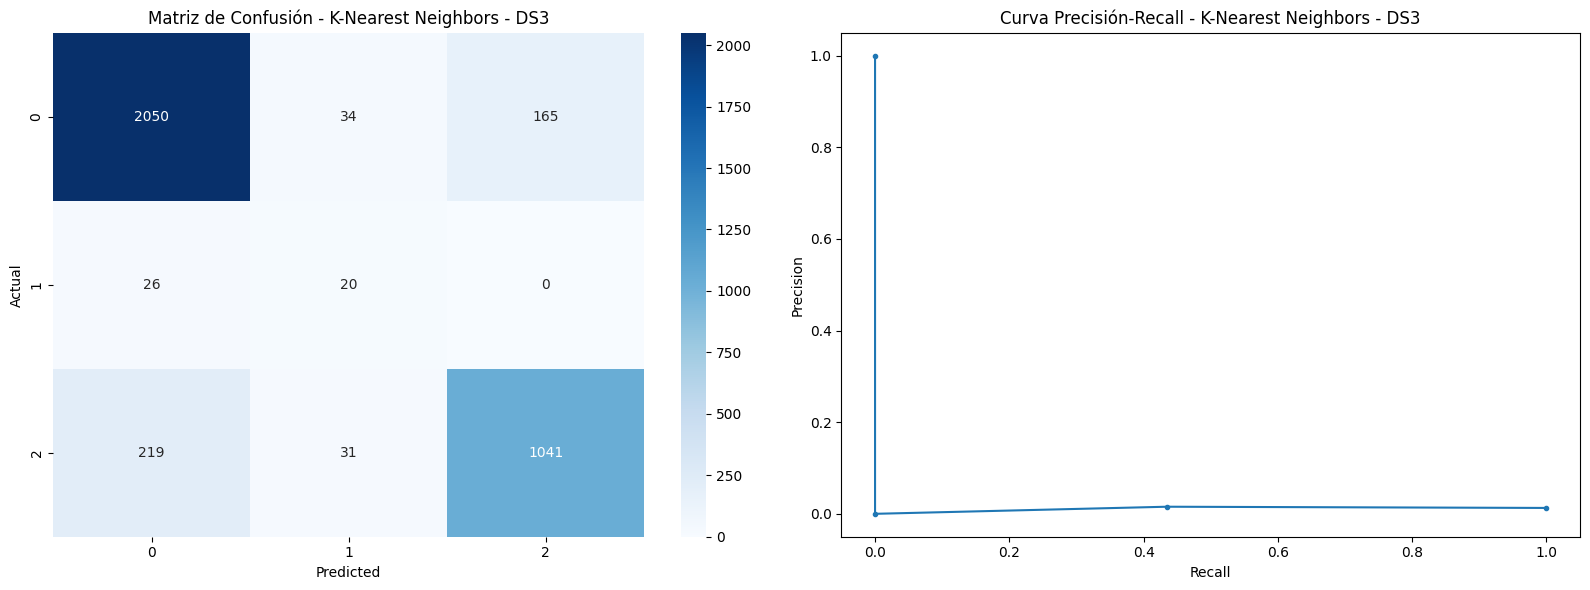

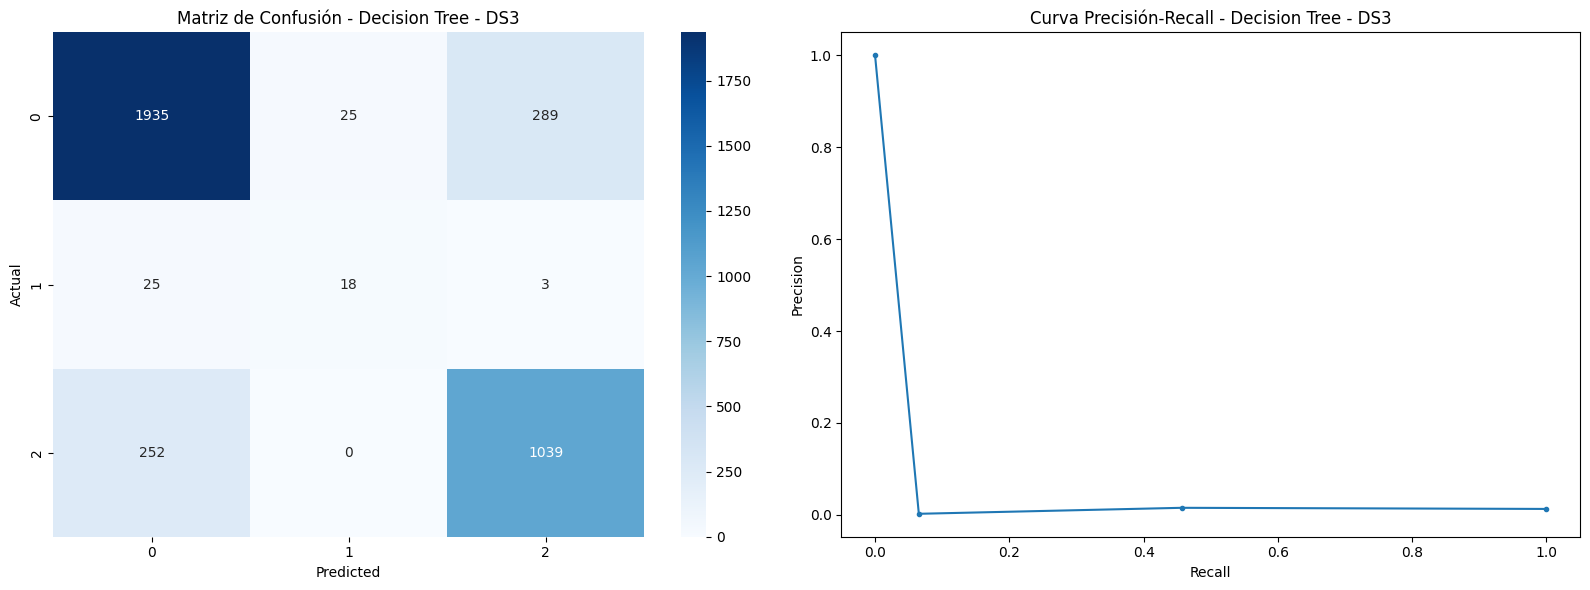

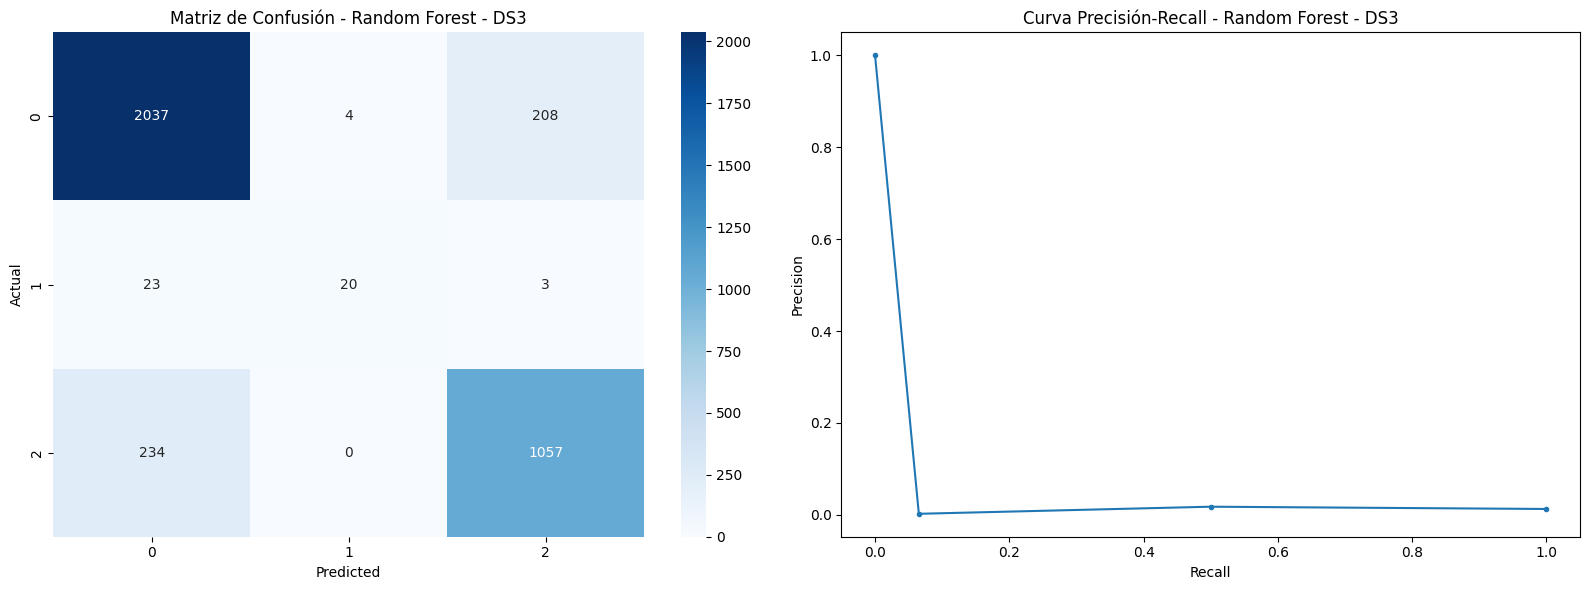

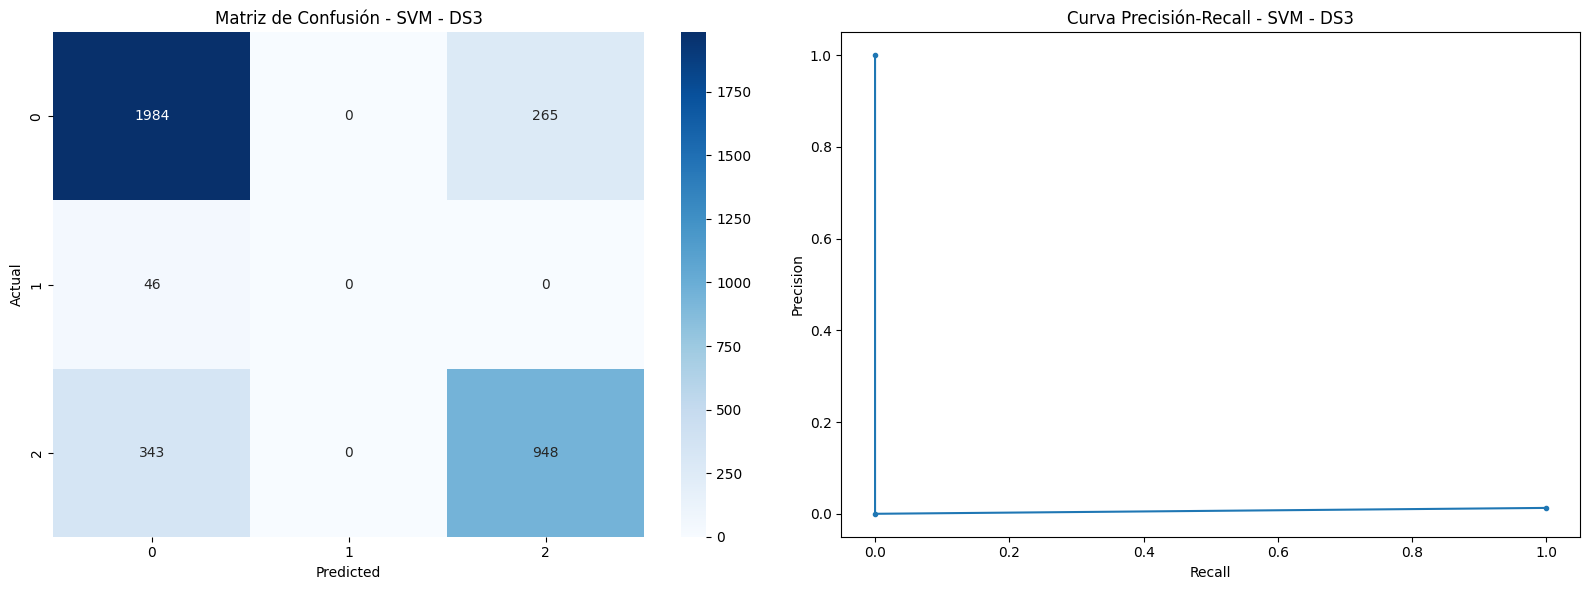

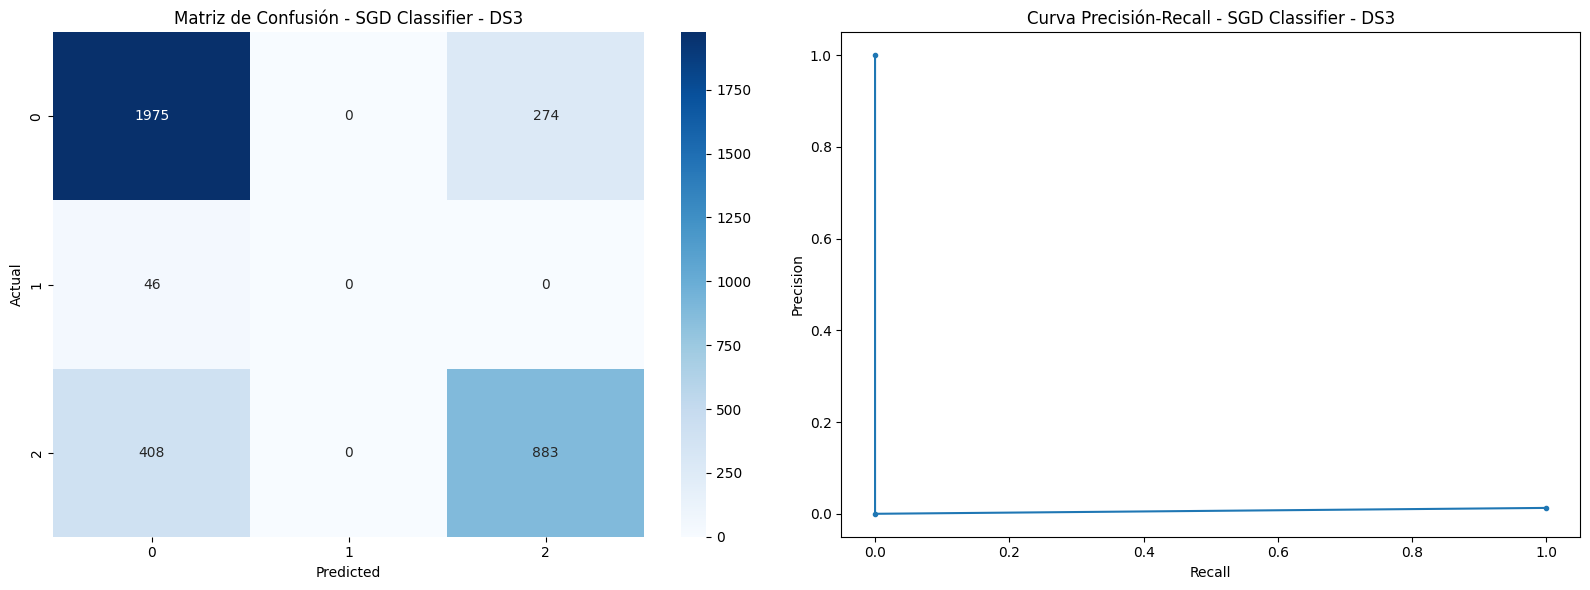

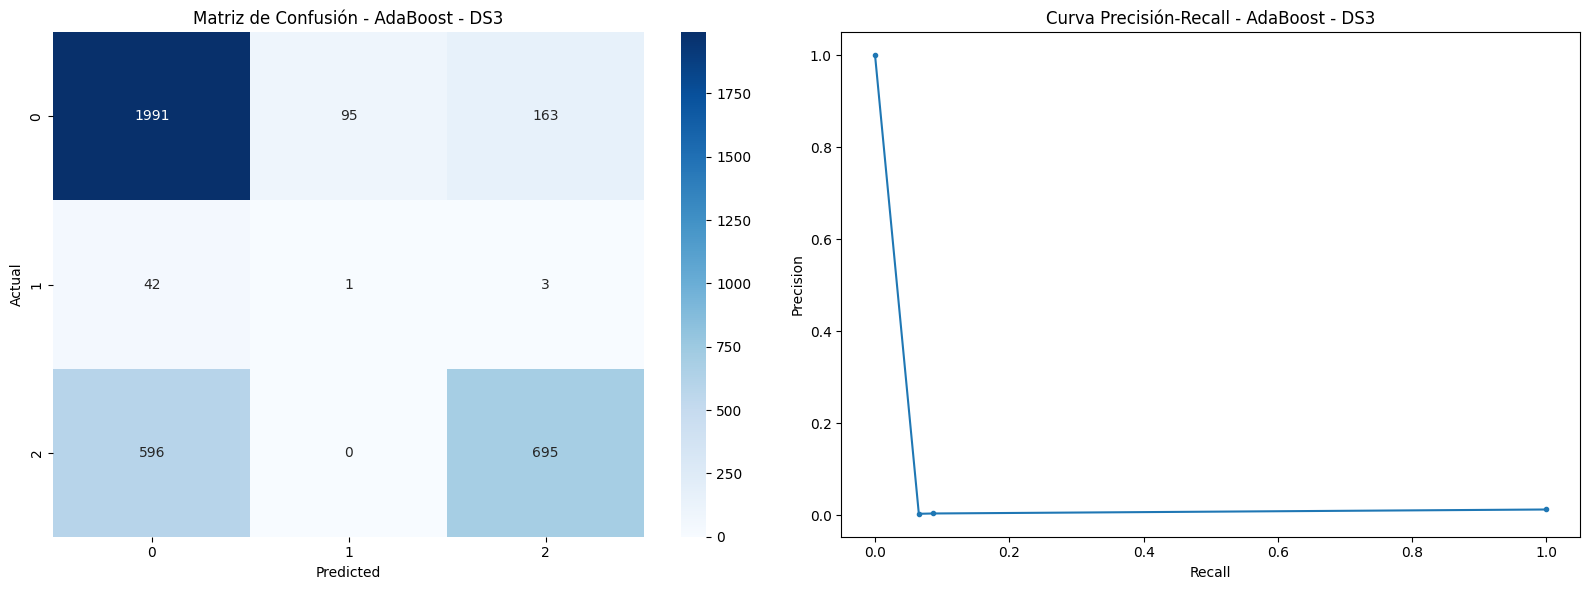

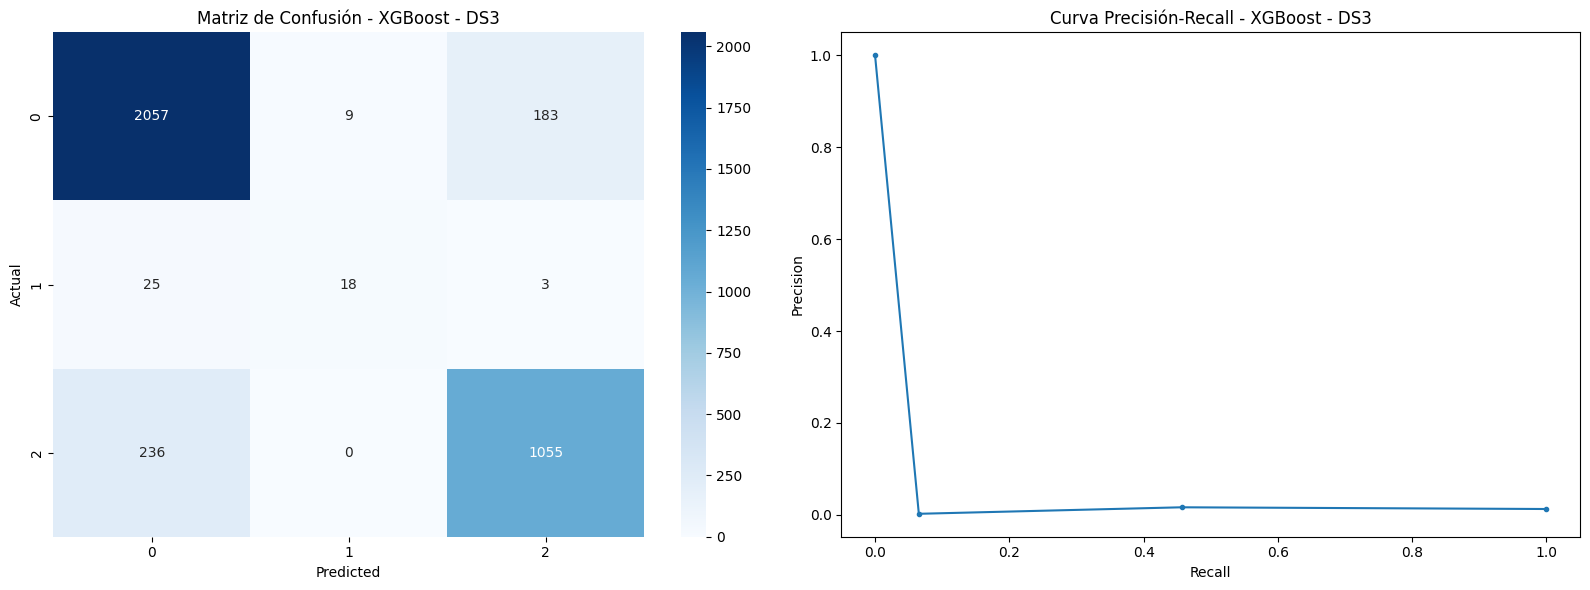

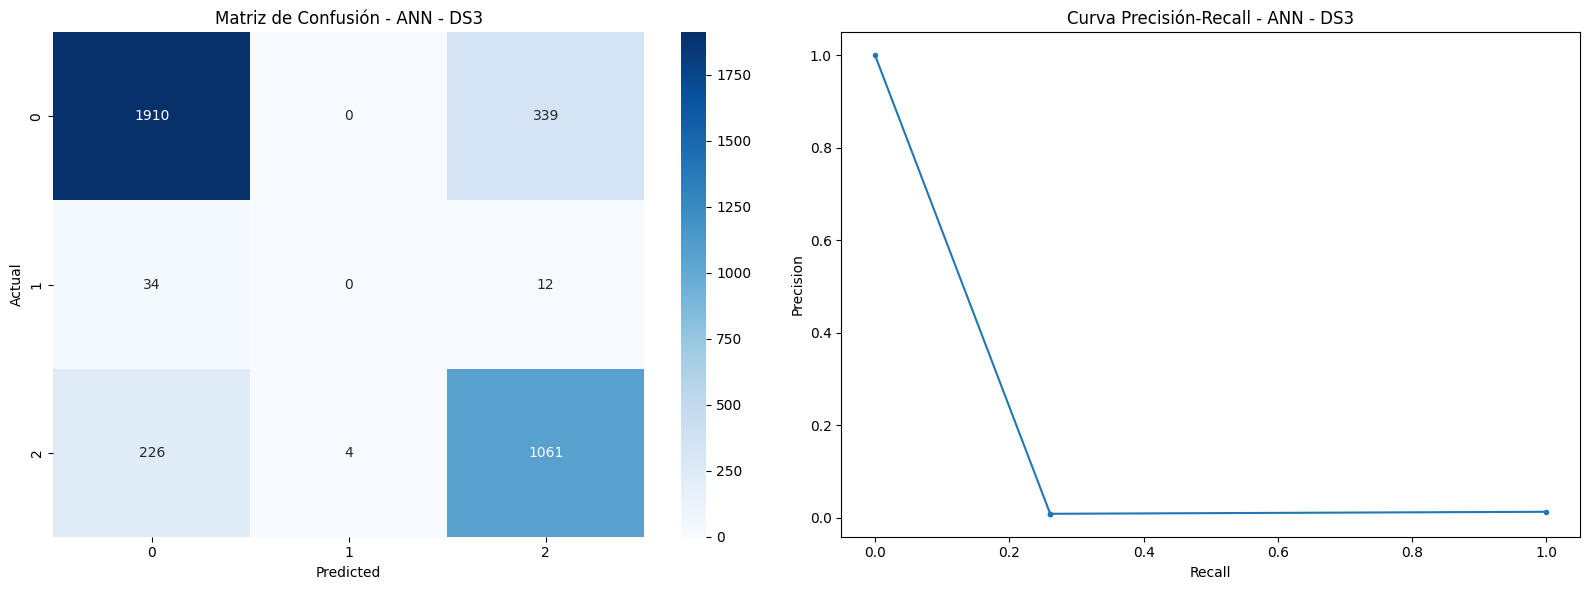

In [ ]:
# Función para entrenar y evaluar cada algoritmo en un dataset
results = []
mejorModelo = None
confusion_matrices = []

for dataset_name, XX in datasets.items(): 
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(XX, np.ravel(Y), test_size=0.3, random_state=semilla)

    for model_name, model in classifiers.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Medir tiempo de predicción
        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_time  # Tiempo en segundos

        # Calcular las métricas
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "F1-Score": report["weighted avg"]["f1-score"],
            "Prediction Time [ms]": prediction_time * 1000  # Convertir a milisegundos
        })

        # Calcular la matriz de confusión y guardarla
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Confusion Matrix": cm
        })

# Convertir resultados a un DataFrame
results_df = pd.DataFrame(results)


In [59]:
print(results_df)

   Dataset                 Model  F1-Score    AUC-PR  Prediction Time [ms]
0      DS1   Logistic Regression  0.937691  0.014277              1.600981
1      DS1  Gaussian Naive Bayes  0.679792  0.023721             12.598991
2      DS1   K-Nearest Neighbors  0.971473  0.016221            190.285206
3      DS1         Decision Tree  0.981658  0.015718              1.735210
4      DS1         Random Forest  0.989889  0.015412             24.508953
5      DS1                   SVM  0.933902  0.016005           2809.858084
6      DS1        SGD Classifier  0.924149  0.013682             13.166189
7      DS1              AdaBoost  0.805695  0.006414             81.675768
8      DS1               XGBoost  0.996073  0.016383             12.501001
9      DS1                   ANN  0.986709  0.016403             10.648012
10     DS2   Logistic Regression  0.890895  0.011505              0.144720
11     DS2  Gaussian Naive Bayes  0.775384  0.011846              1.344919
12     DS2   K-Nearest Ne

In [60]:
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].map(lambda x: f"{x*100:.2f}")

results_df.to_csv("resultadosClasificacion.csv", index=False)

In [61]:
print(Y.shape)
print(U[:,0].shape)

(11953, 1)
(11953,)


Text(0, 0.5, 'Velocidad [m/s]')

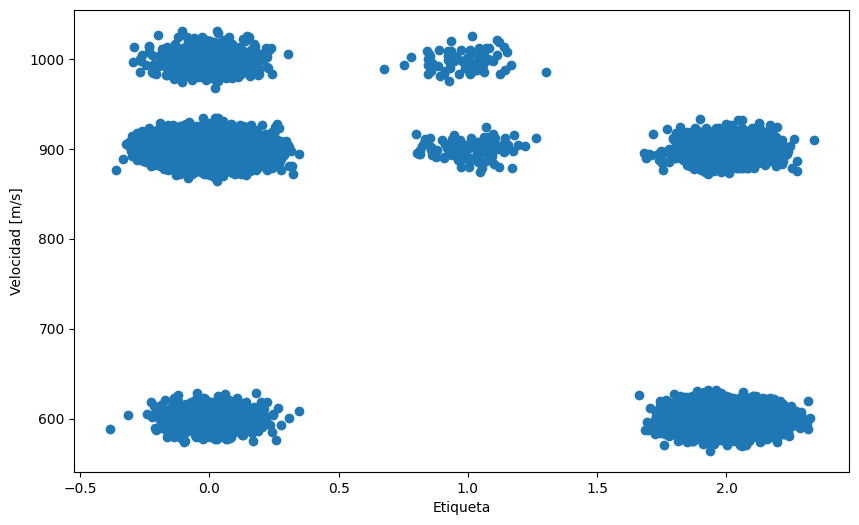

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(Y.ravel()+0.1*np.random.randn(Y.shape[0]), U[:,0].ravel()+10*np.random.randn(U[:,0].shape[0]))
plt.xlabel('Etiqueta')
plt.ylabel('Velocidad [m/s]')

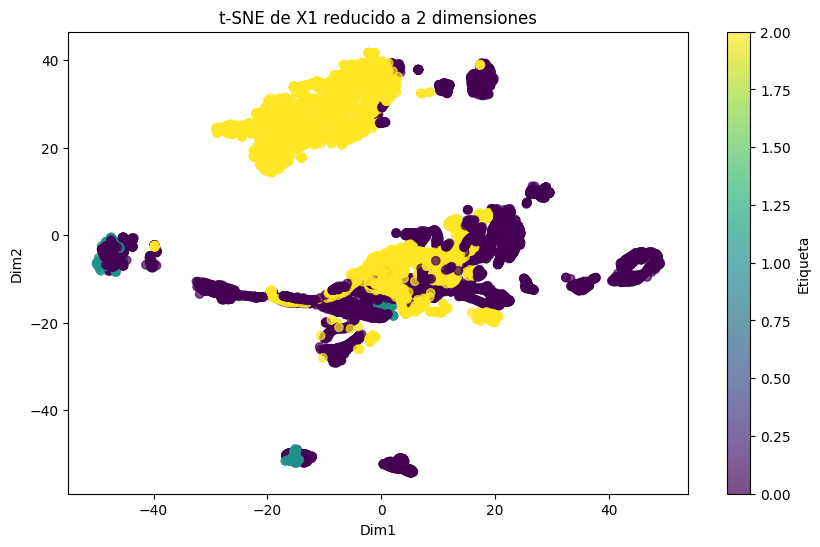

In [63]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=92, perplexity=300)
X1_tsne = tsne.fit_transform(X2)

# Crear un DataFrame con los resultados de t-SNE y las etiquetas
tsne_df = pd.DataFrame(X1_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Etiqueta'] = np.ravel(Y)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['Dim1'], tsne_df['Dim2'], c=tsne_df['Etiqueta'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Etiqueta')
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('t-SNE de X1 reducido a 2 dimensiones')
plt.show()